# Time Series Decomposition

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df = pd.read_csv('ConstructionTimeSeriesDatav2.csv')

# Public Construction Spending - Basic Decomposition Method

First, take a look at the data using a simple visualization. 

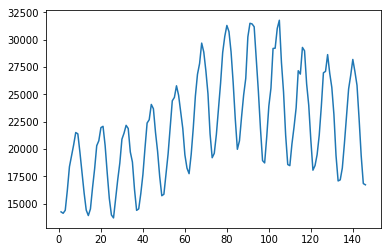

In [2]:
#View the data

plt.plot(df['Month'],df['Public Construction'])

The graph shows the data has a linear upward trend with sesaonal cycles.  

Now generate the intercept and slope values.

In [3]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df['Public Construction'])
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = 18327.939893765724     slope = 52.00857586303297      p_value =  3.028349007007645e-09


Create a new column that calculates a simple regression.

In [4]:
#Create the R1 regression column
def create_regress_col(row, intercept, slope):
    return float(intercept) + float(row['Month']) * slope
    
df['regress'] = df.apply(create_regress_col,args = (intercept,slope),axis = "columns")
df['R1'] = df['Public Construction'] - df['regress']
df.style.format({
    'Public Construction': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,regress,R1
0,1,Jan-02,59516,45273,"14,243","18,380","-4,137"
1,2,Feb-02,58588,44475,"14,113","18,432","-4,319"
2,3,Mar-02,63782,49396,"14,386","18,484","-4,098"
3,4,Apr-02,69504,53283,"16,221","18,536","-2,315"
4,5,May-02,73384,55009,"18,375","18,588",-213
5,6,Jun-02,77182,57801,"19,381","18,640",741
6,7,Jul-02,78863,58494,"20,369","18,692","1,677"
7,8,Aug-02,79460,57953,"21,507","18,744","2,763"
8,9,Sep-02,76542,55157,"21,385","18,796","2,589"
9,10,Oct-02,75710,56023,"19,687","18,848",839


Plot the results of the R1 simple regression column.

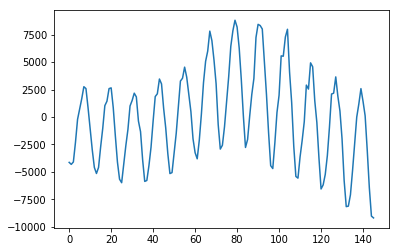

In [5]:
plt.plot(df.index,df.R1)

The resluts of R1 show a seasonality pattern that repeats about every 12 months. 

Check the seasonality using auto-correlation.

C:\Users\rober\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


   Month Month-Year  Total Construction  Private Construction  \
0      1     Jan-02               59516                 45273   
1      2     Feb-02               58588                 44475   
2      3     Mar-02               63782                 49396   
3      4     Apr-02               69504                 53283   
4      5     May-02               73384                 55009   
5      6     Jun-02               77182                 57801   
6      7     Jul-02               78863                 58494   
7      8     Aug-02               79460                 57953   
8      9     Sep-02               76542                 55157   
9     10     Oct-02               75710                 56023   

   Public Construction       regress           R1  lag12  
0                14243  18379.948470 -4136.948470    NaN  
1                14113  18431.957045 -4318.957045    NaN  
2                14386  18483.965621 -4097.965621    NaN  
3                16221  18535.974197 -2314.97419

Text(0.5,0,'Month')

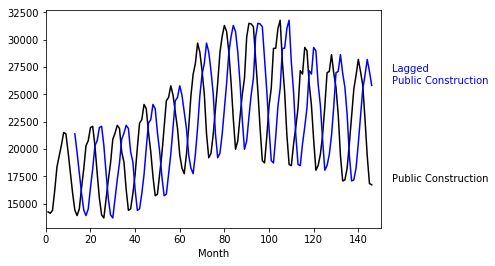

In [6]:
# Create column with lag of 12
lag = 12
df['lag12'] = np.NaN
for i in range(len(df['lag12']))[lag:]:
    df['lag12'].iloc[i] = df['Public Construction'].iloc[i-4]
print(df.head(n=10))

# Compute autocorrelations
for i in range(int(len(df.index)/2)):
    print('autocorrelation, lag =',i,':',df.R1.autocorr(lag = i))
    
fig,ax = plt.subplots()
ax.plot(df['Month'],df['Public Construction'],c='k')
ax.plot(df['Month'],df.lag12,c='b')
ax.set_xlim([0,150])
ax.text(155,17000,'Public Construction',color='k')
ax.text(155,26000,'Lagged\nPublic Construction',color='b')
ax.set_xlabel('Month')

The lagged public construction is highly correlated to the actual Public Construction spending amounts.

Plot each subset of the anual pattern.

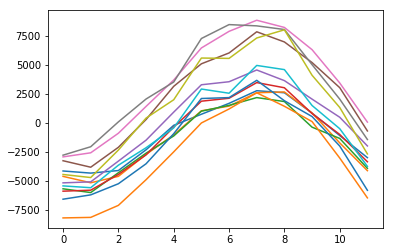

In [7]:
dfQtr = pd.DataFrame()
cycleLen = 12
for i in range(int(len(df.index)/cycleLen)):
    newData = pd.DataFrame({i:df['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})
    newData.index = range(0,len(newData))
    dfQtr = pd.concat([dfQtr,newData],axis=1)

fig,ax = plt.subplots()
ax.plot(dfQtr)

This confirms that the 12 seasonal patterns look the same.

Next, average the spending for each of the years in the data.

              0            1            2            3            4  \
0  -4136.948470 -4600.051380 -5669.154290 -5872.257201 -5157.360111   
1  -4318.957045 -5150.059956 -5991.162866 -5787.265777 -5071.368687   
2  -4097.965621 -4598.068532 -4289.171442 -4436.274352 -3288.377263   
3  -2314.974197 -2716.077108 -2607.180018 -2752.282928 -1488.385839   
4   -212.982773 -1025.085683 -1127.188594  -363.291504   922.605585   
5    741.008651  1036.905741  1004.802830  1862.699920  3274.597010   
6   1677.000075  1438.897165  1503.794254  2114.691344  3534.588434   
7   2762.991499  2588.888589  2171.785679  3461.682768  4544.579858   
8   2588.982923  2654.880013  1831.777103  3016.674192  3630.571282   
9    838.974348   848.871437  -370.231473   798.665617  2039.562706   
10 -1090.034228 -1723.137139 -1339.240049  -997.342959   481.554130   
11 -2991.042804 -4110.145714 -3905.248625 -3345.351535 -1984.454446   

              5            6            7            8            9  \
0  -3

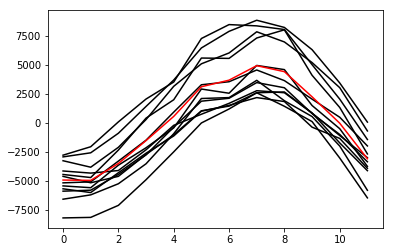

In [8]:
avg = []
for i in range(len(dfQtr.index)):
    avg.append(dfQtr.iloc[i].mean())

dfQtr = pd.concat([dfQtr,pd.DataFrame({'avg':avg})], axis=1)
print(dfQtr)

fig,ax = plt.subplots()
c = 180
for col in dfQtr.columns.values:
    if col == 'avg':
        ax.plot(dfQtr[col], c = 'r')
    else:
        ax.plot(dfQtr[col], c = 'k')

Now, calculate the seasonal affect for each year of spending.

In [22]:
df['S'] = np.NaN
df['R2Public'] = np.NaN
df['Composite'] = np.NaN
df['R2ErrorPublic'] = np.NaN
S = dfQtr['avg'].tolist()
for i in df.index:
    df.loc[i,'S'] = S[i%cycleLen]
    df.loc[i,'R2X'] = df.loc[i,'R1'] - df.loc[i,'S']
    df.loc[i,'Composite'] = df.loc[i,'regress'] + df.loc[i,'S']
    df.loc[i,'R2ErrorX'] = 100*df.loc[i,'R2X'] / df.loc[i,'Public Construction']
df.style.format({
    'Public Construction': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format,
    'S': '{:,.0f}'.format,
    'R2Public': '{:,.0f}'.format,
    'Composite':'{:,.0f}'.format,
    'R2ErrorPublic': '{:.2f}%'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,regress,R1,lag12,S,R2X,Composite,R2ErrorX,R2Public,R2ErrorPublic
0,1,Jan-02,59516,45273,"14,243","18,380","-4,137",nan,"-4,915",778.316,"13,465",5.46455,nan,nan%
1,2,Feb-02,58588,44475,"14,113","18,432","-4,319",nan,"-4,946",626.816,"13,486",4.44141,nan,nan%
2,3,Mar-02,63782,49396,"14,386","18,484","-4,098",nan,"-3,494",-604.184,"14,990",-4.19981,nan,nan%
3,4,Apr-02,69504,53283,"16,221","18,536","-2,315",nan,"-1,523",-792.267,"17,013",-4.88421,nan,nan%
4,5,May-02,73384,55009,"18,375","18,588",-213,nan,555,-767.684,"19,143",-4.17787,nan,nan%
5,6,Jun-02,77182,57801,"19,381","18,640",741,nan,"3,104",-2362.93,"21,744",-12.192,nan,nan%
6,7,Jul-02,78863,58494,"20,369","18,692","1,677",nan,"3,670",-1993.02,"22,362",-9.78456,nan,nan%
7,8,Aug-02,79460,57953,"21,507","18,744","2,763",nan,"4,916",-2152.68,"23,660",-10.0092,nan,nan%
8,9,Sep-02,76542,55157,"21,385","18,796","2,589",nan,"4,400",-1811.27,"23,196",-8.4698,nan,nan%
9,10,Oct-02,75710,56023,"19,687","18,848",839,nan,"2,239",-1400.02,"21,087",-7.11138,nan,nan%


Visualize how the model fits the original Public Construction spending series.

Text(0,0.5,'Construction Spending (in millions of $)')

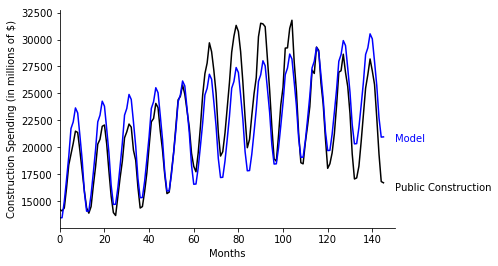

In [10]:
fig, ax = plt.subplots()
ax.plot(df['Public Construction'],c='k')
ax.plot(df['Composite'],c='b')
ax.set_xlim([0,150])
ax.text(150,16000,'Public Construction', color='k')
ax.text(150,20500,'Model', color='b')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Months')
ax.set_ylabel('Construction Spending (in millions of $)')